In [6]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
from tqdm.notebook import tqdm
from typing import Callable, Sequence
import functools as ft
import optax
import treex as tx
from sdf_jax.discretize import discretize2d
from sdf_jax.util import plot2d

# Implicit Geometric Regularization

"Implicit Geometric Regularization for Learning Shapes"
Gropp et al. ICML 2020
https://arxiv.org/abs/2002.10099


![](igr_loss.png)

In [7]:
def surface_loss_fn(model, x):
    return jnp.abs(x)

def eikonal_loss_fn(model, x):
    return (jnp.linalg.norm(jax.grad(model)(x)) - 1.0)**2

@ft.partial(jax.value_and_grad, has_aux=True)
def loss_fn(params, model, xs, lam, key, *, n_samples=1000):
    model = model.merge(params)
    surface_loss = jnp.mean(jax.vmap(ft.partial(surface_loss_fn, model))(xs))
    xs_eik = jrandom.uniform(key, (n_samples, 2)) * 2 - 1.0 # domain [-1,1]^2
    eikonal_loss = jnp.mean(jax.vmap(ft.partial(eikonal_loss_fn, model))(xs_eik))
    loss = surface_loss + lam * eikonal_loss
    return loss, model

@jax.jit
def train_step(model, xs, lam, optimizer, key):
    params = model.filter(tx.Parameter)
    (loss, model), grads = loss_fn(params, model, xs, lam, key)
    new_params = optimizer.update(grads, params)
    model = model.merge(new_params)
    return loss, model, optimizer

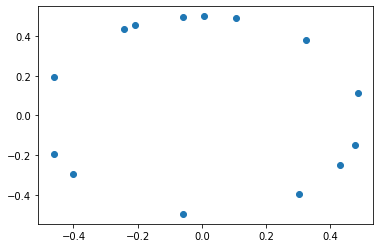

In [8]:
key = jax.random.PRNGKey(0)
key, theta_key = jrandom.split(key, 2)
theta = 2 * jnp.pi * jrandom.uniform(theta_key, (14,))
xs = 0.5 * jnp.vstack([jnp.cos(theta), jnp.sin(theta)]).T
plt.scatter(*xs.T)

(30, 2)


  0%|          | 0/10000 [00:00<?, ?it/s]

[0] loss: 1.2988
[1000] loss: 0.6359
[2000] loss: 0.6358
[3000] loss: 0.6358
[4000] loss: 0.6357
[5000] loss: 0.6356
[6000] loss: 0.6356
[7000] loss: 0.6356
[8000] loss: 0.6364
[9000] loss: 0.6356
[9999] loss: 0.6356


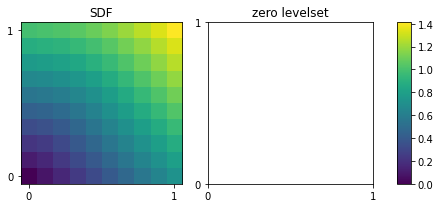

In [11]:
class SimpleNeuralSDF(tx.Module):
    def __init__(self, dims: Sequence[int], act: Callable):
        self.dims = dims
        self.act = act
    @tx.compact
    def __call__(self, x):
        assert x.ndim == 1
        for dim in self.dims:
            x = tx.Linear(dim)(x)
            x = self.act(x)
        y = tx.Linear(1)(x)
        return y[0]

def print_callback(step, loss, model, optimizer):
    print(f"[{step}] loss: {loss:.4f}")

def fit(
    xs,
    # module
    dims=[64,64],
    act=jax.nn.relu,
    lam=1.0,
    # optimizer
    key=jrandom.PRNGKey(1234),
    lr=5e-3,
    steps=100,
    # utils
    cb=print_callback,
    cb_every=10,
):
    key, model_key = jrandom.split(key, 2)
    model = SimpleNeuralSDF(dims=dims, act=act).init(model_key, xs[0])
    optimizer = tx.Optimizer(optax.adam(lr))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    for step in tqdm(range(steps)):
        key, step_key = jrandom.split(key, 2)
        loss, model, optimizer = train_step(model, xs, lam, optimizer, step_key)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    cb(step, loss, model, optimizer)
    return loss, model

key = jax.random.PRNGKey(0)
key, theta_key = jrandom.split(key, 2)
theta = 2 * jnp.pi * jrandom.uniform(theta_key, (30,))
xs = jnp.vstack([jnp.cos(theta), jnp.sin(theta)]).T
print(xs.shape)
loss, model = fit(xs, steps=10000, cb_every=1000)
plot2d(model)

  0%|          | 0/100 [00:00<?, ?it/s]

[0] loss: 0.6356
[10] loss: 0.6356
[20] loss: 0.6356
[30] loss: 0.6356
[40] loss: 0.6356
[50] loss: 0.6356
[60] loss: 0.6356
[70] loss: 0.6356
[80] loss: 0.6356
[90] loss: 0.6356


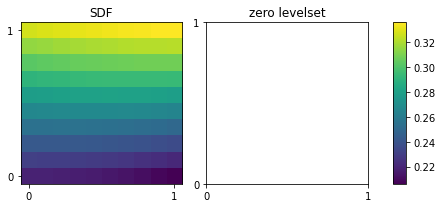

In [10]:
loss, model = fit(xs, act=jax.nn.softplus, lam=0.0)
plot2d(model)

TODO: geometric init

TODO: sampling of eikonal points as in paper